In [1]:
from ib_insync import *#IB, Future, util, Contract
import pandas as pd
import datetime as dt
import nest_asyncio
nest_asyncio.apply()
import os

import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import os

sys.path.append('../')
from functions import *
from functions.preprocessing import *
from functions.swing_points import *
from functions.fvg import *
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Establish connection to IB Gateway/TWS
ib = IB()
ib.connect("127.0.0.1", 7497, clientId=1)  # Update with your TWS/Gateway connection details

<IB connected to 127.0.0.1:7497 clientId=1>

## Update ES and NQ data

In [2]:
df_es = pd.read_parquet('df_es.parquet')
df_nq = pd.read_parquet('df_nq.parquet')
df_dx = pd.read_parquet('df_dx.parquet')
df_ym = pd.read_parquet('df_ym.parquet')

In [12]:
contracts = [ContFuture(symbol='ES', exchange='CME'), ContFuture(symbol='NQ', exchange='CME'), ContFuture(symbol='YM', exchange='CBOT')]
contracts = [ib.qualifyContracts(c) for c in contracts]
symbols = ['ES', 'NQ', 'YM']
symbols

['ES', 'NQ', 'YM']

In [14]:
for i, s in enumerate(symbols):
    bars = ib.reqHistoricalData(
            contracts[i][0],
            endDateTime='',#end_datetime.strftime('%Y%m%d-%H:%M:%S'),
            durationStr='2 D',
            barSizeSetting='1 min',
            whatToShow='TRADES',
            useRTH=False,
            formatDate=1,
            timeout=0
        )

    df = util.df(bars)
    df.set_index("date", inplace=True)
    df.index = pd.to_datetime(df.index)
    df.drop(columns=['volume', 'average', 'barCount'], inplace=True)
    df = df.tz_convert('America/New_York')
    df.to_csv(f'df_{s}.csv')

In [15]:
df_es_c = pd.read_csv('df_ES.csv', parse_dates=True, index_col='date')
df_es_c.index = df_es_c.index.tz_convert('America/New_York')

df_nq_c = pd.read_csv('df_NQ.csv', parse_dates=True, index_col='date')
df_nq_c.index = df_nq_c.index.tz_convert('America/New_York')

df_ym_c = pd.read_csv('df_YM.csv', parse_dates=True, index_col='date')
df_ym_c.index = df_ym_c.index.tz_convert('America/New_York')

In [16]:
df_es = pd.concat([df_es, df_es_c])
df_es = df_es[~df_es.index.duplicated(keep='last')].astype('float32')
df_es.index.name = 'datetime'

df_nq = pd.concat([df_nq, df_nq_c])
df_nq = df_nq[~df_nq.index.duplicated(keep='last')].astype('float32')
df_nq.index.name = 'datetime'

df_ym = pd.concat([df_nq, df_ym_c])
df_ym = df_ym[~df_ym.index.duplicated(keep='last')].astype('float32')
df_ym.index.name = 'datetime'

# df_dx = pd.concat([df_dx, df_dx_c])
# df_dx = df_dx[~df_dx.index.duplicated(keep='last')].astype('float32')
# df_dx.index.name = 'datetime'

In [17]:
df_es.to_parquet('df_es.parquet', index=True)
df_nq.to_parquet('df_nq.parquet', index=True)
df_ym.to_parquet('df_ym.parquet', index=True)

## Update DXY Data

In [18]:
from tda import auth, client
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Replace the placeholders with your TD Ameritrade credentials
api_key = '0TSGZDINMI3LAFX5RRGI65GTXZ310SDF'
redirect_uri = 'http://localhost/test'
token_path = 'key.txt'

# Set up authentication
try:
    client = auth.easy_client(
        api_key=api_key,
        redirect_uri=redirect_uri,
        token_path=token_path,
        webdriver_func=webdriver.Chrome
    )
except FileNotFoundError:
    from tda import client
    client = auth.client_from_token_file(token_path, api_key)


In [19]:
# Define the symbol and other parameters
symbol = "$DXY"
period_type = client.PriceHistory.PeriodType.DAY
period = client.PriceHistory.Period.TWO_DAYS
frequency_type = client.PriceHistory.FrequencyType.MINUTE
frequency = client.PriceHistory.Frequency.EVERY_MINUTE

# Request historical data
response = client.get_price_history(
    symbol,
    period_type=period_type,
    period=period,
    frequency_type=frequency_type,
    frequency=frequency,
    end_datetime= dt.datetime.today() + dt.timedelta(days=1)
)

# Convert response to DataFrame
df_dx_c = pd.DataFrame(response.json()['candles'])[:-1]
df_dx_c['date'] = pd.to_datetime(df_dx_c['datetime'], unit='ms')
df_dx_c = df_dx_c.set_index('date')
df_dx_c.drop(columns=['datetime', 'volume'], inplace=True)
df_dx_c.index = df_dx_c.index.tz_localize('America/New_York')

In [21]:
df_dx = pd.concat([df_dx, df_dx_c])
df_dx = df_dx[~df_dx.index.duplicated(keep='last')].astype('float32')
df_dx = df_dx.drop(df_dx[df_dx.high > 1000].index) #fix tda giving incorrect candles (some are at like 30000)
df_dx.index.name = 'datetime'
df_dx.to_parquet('df_dx.parquet', index=True)

## Process Updated Data

In [3]:
df_list = []
for df in [df_es, df_nq, df_ym, df_dx]:
    lookback = 20
    timeframes = ['1T', '5T', '15T', '1H', '4H', '1B']
    timeframes_fvg = ['1T', '5T', '15T', '1H', '4H', '1B']
    df = identify_swing_points_optimized(df, timeframes, get_swing_values=False, interpolation_method='None')
    df = identify_fair_value_gaps_optimized(df, timeframes_fvg, get_high_low=False)
    df_list.append(df)

In [4]:
df = pd.merge(df_list[0], df_list[1], 'inner', 'datetime', suffixes=('_es', '_nq'))
del(df_es)
del(df_nq)

df_list[2].columns = [c + '_ym' for c in df_list[2].columns]
df = pd.merge(df, df_list[2], 'inner', 'datetime')
del(df_ym)

df_list[3].columns = [c + '_dx' for c in df_list[3].columns]
df = pd.merge(df, df_list[3], 'inner', 'datetime')
del(df_dx)
del(df_list)

In [5]:
df = df.assign(
    month=df.index.month,
    day=df.index.day,
    hour=df.index.hour,
    minute=df.index.minute,
    day_of_week=df.index.dayofweek.astype('int8')
)

In [6]:
def add_cyclic_date_features(df, column, max_val):
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / max_val).astype('float32')
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / max_val).astype('float32')
    df.drop(columns=column, inplace=True)

add_cyclic_date_features(df, 'month', 12)
add_cyclic_date_features(df, 'day', 31)
add_cyclic_date_features(df, 'hour', 23)
add_cyclic_date_features(df, 'minute', 60)
add_cyclic_date_features(df, 'day_of_week', 6)

In [7]:
# Get weekly open and closes and midnight open
df['weekly_open'] = df.open_es.resample('W-SAT', label='left').first().reindex(df.index, method='ffill')
df['weekly_close'] = df.close_es.resample('W-SAT', label='left').first().shift(1).reindex(df.index, method='ffill')
df['daily_open'] = df.open_es.resample('D', label='left').first().reindex(df.index, method='ffill')

## Get News Data

In [27]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from dateutil.rrule import rrule, WEEKLY
import datetime as dt
import requests

In [28]:
price_cols = df.columns[(df>1).any()]
cyclical_cols = [c for c in df.columns if re.match(r'^.*(_sin|_cos)', c)]
swing_cols = [c for c in df.columns if 'swing' in c]
fvg_cols = [c for c in df.columns if 'fair' in c]


In [29]:
# Define start and end dates
start_date = dt.datetime.now() - dt.timedelta(weeks=2)
end_date = dt.datetime.now()

dates = [dt for dt in rrule(WEEKLY, dtstart=start_date, until=end_date)]

# Initialize an empty DataFrame to store all data
new_data = pd.DataFrame(columns=['Date', 'Time', 'Currency', 'Event', 'Impact'])

for d in dates:
    url = 'https://www.forexfactory.com/calendar?week={}'.format(d.strftime('%b%d.%Y').lower())
    
    # Make a request to the website
    req = Request(url , headers={'User-Agent': 'Mozilla/5.0'})

    page = urlopen(req).read()
    soup = BeautifulSoup(page, 'html.parser')
    
    data = []
    for row in soup.find_all('tr', {'class': 'calendar_row'}):
        event = row.find('td', {'class': 'calendar__event'}).text.strip()
        if event:
            date = (row.find('td', {'class': 'calendar__date'}).text.strip() + ' ' + str(d.year)) if row.find('td', {'class': 'calendar__date'}).text.strip() else np.nan
            time = row.find('td', {'class': 'calendar__time'}).text.strip()
            currency = row.find('td', {'class': 'calendar__currency'}).text.strip()

            impact = row.find('td', {'class': 'calendar__impact'}).find('span').get('title').split(' ')[0]

            data.append([date, time, currency, event, impact])
            
    temp_df = pd.DataFrame(data, columns=['Date', 'Time', 'Currency', 'Event', 'Impact'])
    new_data = pd.concat([new_data, temp_df], ignore_index=True)

new_data['Date'] = new_data.Date.ffill()
new_data['Date'] = new_data['Date'].apply(lambda x: dt.datetime.strptime(x, '%a%b %d %Y'))
new_data['Time'] = new_data['Time'].apply(lambda x : x[:-2])
new_data['Time'] = new_data.Time.replace('', np.nan).replace('All D', '00:00')
new_data['Time'] = new_data.Time.ffill()

new_data = new_data.query('(Impact == "High" or Impact == "Medium") and Currency == "USD"')
new_data['Time'] = pd.to_timedelta(new_data['Time'] + ':00')  # Add ':00' to convert the time string to 'HH:MM:SS' format
new_data['datetime'] = new_data['Date'] + new_data['Time']
new_data = new_data.set_index('datetime').drop(columns=['Date', 'Time', 'Currency'])
new_data.index = new_data.index.tz_localize('America/New_York')

new_data = new_data.pivot_table(index='datetime', columns='Event', values='Impact', fill_value=0, aggfunc='first').replace({"Medium": 1, "High": 1}).join(
pd.get_dummies(new_data.Impact).groupby('datetime').agg(max)
)

### Load News Data and add new data

In [30]:
all_data = pd.read_csv('news_data_2008.csv').set_index('datetime')
all_data = pd.get_dummies(all_data, prefix='news_')

In [31]:
all_data = pd.concat([all_data, new_data])
all_data = all_data[~all_data.index.duplicated(keep='last')].fillna(0).astype(bool)
all_data.to_csv('news_data_2008.csv')

## Join news data with df

In [32]:
all_data.columns = ['news_' + c for c in all_data.columns]
df = df.join(all_data).fillna(0)
df.index = pd.to_datetime(df.index)

## Save Data 

In [8]:
df = df.fillna(0)

In [9]:
import re

# Define the resample timeframes
timeframes = ['1T', '5T', '15T', '1H', '4H', '1B']

resample_cols = {
    '1T': r'((open|high|low|close)_.*)|(swing_1T_.*)|(fair_value_gap_1T)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '5T': r'((open|high|low|close)_.*)|(swing_5T_.*)|(fair_value_gap_5T)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '15T': r'((open|high|low|close)_.*)|(swing_15T_.*)|(fair_value_gap_15T)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '1H': r'((open|high|low|close)_.*)|(swing_1H_.*)|(fair_value_gap_1H)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '4H': r'((open|high|low|close)_.*)|(swing_4H_.*)|(fair_value_gap_4H)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
    '1B': r'((open|high|low|close)_.*)|(swing_1B_.*)|(fair_value_gap_1B)|(minute.*)|(hour.*)|(day.*)|(month.*)|(day_of_week.*)|(weekly_(open|close))|(daily_open)|(^news_.*)',
}

aggs = {
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'swing_.*': 'first',
    'fair_value_gap_.*': lambda x: x[x!=0].iloc[0] if len(x[x!=0]) > 0 else 0,
    'minute.*': 'first',
    'hour.*': 'first',
    'day.*': 'first',
    'month.*': 'first',
    'day_of_week_.*': 'first',
    'weekly_open': 'first',
    'weekly_close': 'first',
    'daily_open': 'first',
    'news_.*' : 'max'
}

keep_cols = {}
for timeframe, regex in resample_cols.items():
    cols = []
    for col in df.columns:
        if re.match(regex, col):
            cols.append(col)
    agg_cols = {}
    for col in cols:
        for agg in aggs:
            if re.match(agg, col):
                agg_cols[col] = aggs[agg]
                break
    keep_cols[timeframe] = agg_cols


In [31]:
from tsfracdiff import FractionalDifferentiator
import pickle
import pytz



market_open = df.index[-1].replace(month=5, day=16, hour=9, minute=29)
one_year_ago = (dt.datetime.today() - dt.timedelta(days=370)).replace(tzinfo=pytz.timezone('America/New_York'))
df_save = df.loc[one_year_ago:market_open]

df_save.index = pd.to_datetime(df_save.index)
seq_length = 90
idx_lookback = -seq_length*2 * np.array([1,5,15,60,240,1440])

data = []

for t, idx in zip(timeframes, idx_lookback):
    print(t)
    if t == '1T':
        temp = df_save[idx:][[c for c in df_save.columns if re.match(resample_cols['1T'], c)]].dropna()
    elif t == '4H':
        temp = df_save[idx:].resample(t, offset='2H').agg(keep_cols[t]).dropna()
    else:
        temp = df_save[idx:].resample(t).agg(keep_cols[t]).dropna()
        
    #with open(f'../Dense/FractionalDifferentiator_{t}.pkl', 'rb') as file:
    #    s = pickle.load(file)
    #temp.loc[: , price_cols] = s.Transform(temp[price_cols])  
        
    data.append(temp.dropna()[-90:].values.astype('float32'))
    
data = np.array(data)
data = data.reshape(1, *data.shape)

1T
5T
15T
1H
4H
1B


In [32]:
import pickle
from sklearn.preprocessing import *

with open('../Dense/StandardScaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# only get columns we want to standardize
cols_to_standardize = [temp.columns.get_loc(c) for c in [c for c in temp.columns if any([s in c for s in ['open', 'high', 'low', 'close']])]]
a = data[:,:,:,cols_to_standardize]

# Fit the scaler to the data and transform X_train
scaler = StandardScaler()
data[:,:,:,cols_to_standardize] = scaler.fit_transform(a.reshape((-1, a.shape[-1]))).reshape(a.shape)

data = np.split(data, 6, axis=1)
data = [element.squeeze(axis=1) for element in data]

In [33]:
import tensorflow as tf

morning_high_model = tf.keras.models.load_model('../Dense/best_model_high.keras', compile=False)
morning_high_model.optimizer = tf.keras.optimizers.legacy.Adam()
morning_high_model.compile()

morning_low_model = tf.keras.models.load_model('../Dense/best_model_low.keras', compile=False)
morning_low_model.optimizer = tf.keras.optimizers.legacy.Adam()
morning_low_model.compile()

morning_high_predictions = morning_high_model.predict(data)
morning_low_predictions = morning_low_model.predict(data)

Metal device set to: Apple M1 Pro
1/1 [==============================] - 0s 95ms/step


In [34]:
morning_high_predictions[0][0], morning_low_predictions[0][0]

(25.843868, -4.868211)

Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Peer closed connection.


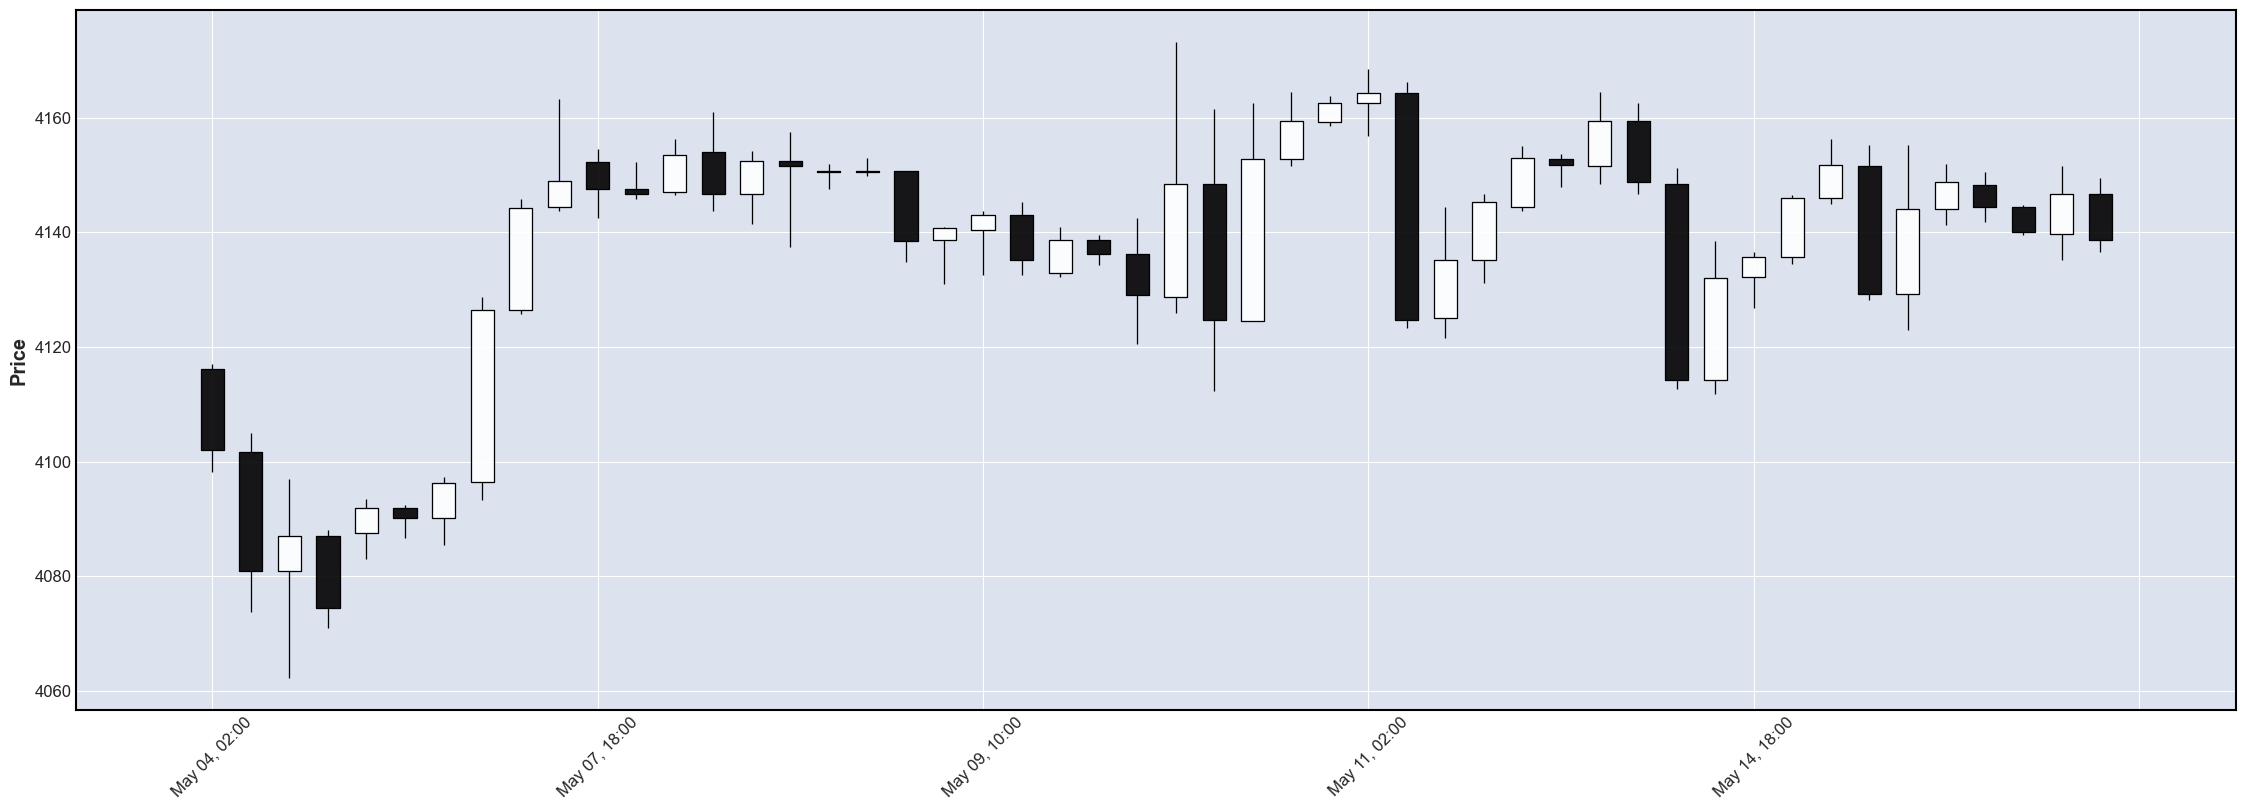

In [278]:
mpf.plot(temp[-50:].dropna().rename(columns= {'open_es' : 'open', 'high_es' : 'high', 'low_es' : 'low', 'close_es' : 'close'}).astype('float32'), type='candle', figsize=(30,10))


In [305]:
df_4H.tail()

,open_es,high_es,low_es,close_es,swing_4H_es,fair_value_gap_4H_es,open_nq,high_nq,low_nq,close_nq,swing_4H_nq,fair_value_gap_4H_nq,open_dx,high_dx,low_dx,close_dx,swing_4H_dx,fair_value_gap_4H_dx,open_ym,high_ym,low_ym,close_ym,swing_4H_ym,fair_value_gap_4H_ym,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,day_of_week_sin,day_of_week_cos,weekly_open,weekly_close,daily_open,news_10-y Bond Auction,news_30-y Bond Auction,news_ADP Non-Farm Employment Change,news_Advance GDP Price Index q/q,news_Advance GDP q/q,news_Assist Treasury Sec Kashkari Speaks,news_Average Hourly Earnings m/m,news_Bank Stress Test Results,news_Beige Book,news_Building Permits,news_Business Inventories m/m,news_CB Consumer Confidence,news_CB Leading Index m/m,news_CPI m/m,news_CPI y/y,news_Capacity Utilization Rate,news_Chicago PMI,news_Congressional Elections,news_Core CPI m/m,news_Core Durable Goods Orders m/m,news_Core PCE Price Index m/m,news_Core PPI m/m,news_Core Retail Sales m/m,news_Crude Oil Inventories,news_Current Account,news_Durable Goods Orders m/m,news_Economic Stabilization Bill Vote,news_Empire State Manufacturing Index,news_Employment Cost Index q/q,news_Existing Home Sales,news_FOMC Economic Projections,news_FOMC Meeting Minutes,news_FOMC Member Barkin Speaks,news_FOMC Member Bostic Speaks,news_FOMC Member Bowman Speaks,news_FOMC Member Brainard Speaks,news_FOMC Member Bullard Speaks,news_FOMC Member Clarida Speaks,news_FOMC Member Collins Speaks,news_FOMC Member Daly Speaks,news_FOMC Member Dudley Speaks,news_FOMC Member Duke Speaks,news_FOMC Member Evans Speaks,news_FOMC Member Fischer Speaks,news_FOMC Member Fisher Speaks,news_FOMC Member Geithner Speaks,news_FOMC Member George Speaks,news_FOMC Member Harker Speaks,news_FOMC Member Hoenig Speaks,news_FOMC Member Kaplan Speaks,news_FOMC Member Kashkari Speaks,news_FOMC Member Kocherlakota Speaks,news_FOMC Member Kohn Speaks,news_FOMC Member Kroszner Speaks,news_FOMC Member Lacker Speaks,news_FOMC Member Lockhart Speaks,news_FOMC Member Mester Speaks,news_FOMC Member Mishkin Speaks,news_FOMC Member Pianalto Speaks,news_FOMC Member Plosser Speaks,news_FOMC Member Powell Speaks,news_FOMC Member Quarles Speaks,news_FOMC Member Raskin Speaks,news_FOMC Member Rosengren Speaks,news_FOMC Member Stein Speaks,news_FOMC Member Stern Speaks,news_FOMC Member Tarullo Speaks,news_FOMC Member Waller Speaks,news_FOMC Member Warsh Speaks,news_FOMC Member Williams Speaks,news_FOMC Member Yellen Speaks,news_FOMC Press Conference,news_FOMC Statement,news_Factory Orders m/m,news_Fed Announcement,news_Fed Chair Powell Speaks,news_Fed Chair Powell Testifies,news_Fed Chair Yellen Speaks,news_Fed Chair Yellen Testifies,news_Fed Chairman Bernanke Speaks,news_Fed Chairman Bernanke Testifies,news_Fed Chairman Nomination Vote,news_Fed Gov Nomination Hearings,news_Fed Monetary Policy Report,news_Federal Budget Balance,news_Federal Funds Rate,news_Final GDP Price Index q/q,news_Final GDP q/q,news_Final Manufacturing PMI,news_Final Services PMI,news_Final Wholesale Inventories m/m,news_Flash Manufacturing PMI,news_Flash Services PMI,news_Goods Trade Balance,news_Housing Starts,news_ISM Manufacturing PMI,news_ISM Manufacturing Prices,news_ISM Services PMI,news_Import Prices m/m,news_Industrial Production m/m,news_JOLTS Job Openings,news_Mortgage Delinquencies,news_NAHB Housing Market Index,news_New Home Sales,news_Non-Farm Employment Change,news_PPI m/m,news_Pending Home Sales m/m,news_Personal Income m/m,news_Personal Spending m/m,news_Philly Fed Manufacturing Index,news_Prelim GDP Price Index q/q,news_Prelim GDP q/q,news_Prelim Nonfarm Productivity q/q,news_Prelim Unit Labor Costs q/q,news_Prelim UoM Consumer Sentiment,news_Prelim UoM Inflation Expectations,news_President Biden Speaks,news_President Bush Speaks,news_President Obama Speaks,news_President Trump Speaks,news_Presidential Election,news_Retail Sales m/m,news_Revised Nonfarm Productivity q/q,news_Revised UoM Consumer Sentiment,new

In [316]:
pd.DataFrame(data[4][0], columns=temp.columns)

,open_es,high_es,low_es,close_es,swing_1B_es,fair_value_gap_1B_es,open_nq,high_nq,low_nq,close_nq,swing_1B_nq,fair_value_gap_1B_nq,open_ym,high_ym,low_ym,close_ym,swing_1B_ym,fair_value_gap_1B_ym,open_dx,high_dx,low_dx,close_dx,swing_1B_dx,fair_value_gap_1B_dx,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos,day_of_week_sin,day_of_week_cos,weekly_open,weekly_close,daily_open,news_10-y Bond Auction,news_30-y Bond Auction,news_ADP Non-Farm Employment Change,news_Advance GDP Price Index q/q,news_Advance GDP q/q,news_Assist Treasury Sec Kashkari Speaks,news_Average Hourly Earnings m/m,news_Bank Stress Test Results,news_Beige Book,news_Building Permits,news_Business Inventories m/m,news_CB Consumer Confidence,news_CB Leading Index m/m,news_CPI m/m,news_CPI y/y,news_Capacity Utilization Rate,news_Chicago PMI,news_Congressional Elections,news_Core CPI m/m,news_Core Durable Goods Orders m/m,news_Core PCE Price Index m/m,news_Core PPI m/m,news_Core Retail Sales m/m,news_Crude Oil Inventories,news_Current Account,news_Durable Goods Orders m/m,news_Economic Stabilization Bill Vote,news_Empire State Manufacturing Index,news_Employment Cost Index q/q,news_Existing Home Sales,news_FOMC Economic Projections,news_FOMC Meeting Minutes,news_FOMC Member Barkin Speaks,news_FOMC Member Bostic Speaks,news_FOMC Member Bowman Speaks,news_FOMC Member Brainard Speaks,news_FOMC Member Bullard Speaks,news_FOMC Member Clarida Speaks,news_FOMC Member Collins Speaks,news_FOMC Member Daly Speaks,news_FOMC Member Dudley Speaks,news_FOMC Member Duke Speaks,news_FOMC Member Evans Speaks,news_FOMC Member Fischer Speaks,news_FOMC Member Fisher Speaks,news_FOMC Member Geithner Speaks,news_FOMC Member George Speaks,news_FOMC Member Harker Speaks,news_FOMC Member Hoenig Speaks,news_FOMC Member Kaplan Speaks,news_FOMC Member Kashkari Speaks,news_FOMC Member Kocherlakota Speaks,news_FOMC Member Kohn Speaks,news_FOMC Member Kroszner Speaks,news_FOMC Member Lacker Speaks,news_FOMC Member Lockhart Speaks,news_FOMC Member Mester Speaks,news_FOMC Member Mishkin Speaks,news_FOMC Member Pianalto Speaks,news_FOMC Member Plosser Speaks,news_FOMC Member Powell Speaks,news_FOMC Member Quarles Speaks,news_FOMC Member Raskin Speaks,news_FOMC Member Rosengren Speaks,news_FOMC Member Stein Speaks,news_FOMC Member Stern Speaks,news_FOMC Member Tarullo Speaks,news_FOMC Member Waller Speaks,news_FOMC Member Warsh Speaks,news_FOMC Member Williams Speaks,news_FOMC Member Yellen Speaks,news_FOMC Press Conference,news_FOMC Statement,news_Factory Orders m/m,news_Fed Announcement,news_Fed Chair Powell Speaks,news_Fed Chair Powell Testifies,news_Fed Chair Yellen Speaks,news_Fed Chair Yellen Testifies,news_Fed Chairman Bernanke Speaks,news_Fed Chairman Bernanke Testifies,news_Fed Chairman Nomination Vote,news_Fed Gov Nomination Hearings,news_Fed Monetary Policy Report,news_Federal Budget Balance,news_Federal Funds Rate,news_Final GDP Price Index q/q,news_Final GDP q/q,news_Final Manufacturing PMI,news_Final Services PMI,news_Final Wholesale Inventories m/m,news_Flash Manufacturing PMI,news_Flash Services PMI,news_Goods Trade Balance,news_Housing Starts,news_ISM Manufacturing PMI,news_ISM Manufacturing Prices,news_ISM Services PMI,news_Import Prices m/m,news_Industrial Production m/m,news_JOLTS Job Openings,news_Mortgage Delinquencies,news_NAHB Housing Market Index,news_New Home Sales,news_Non-Farm Employment Change,news_PPI m/m,news_Pending Home Sales m/m,news_Personal Income m/m,news_Personal Spending m/m,news_Philly Fed Manufacturing Index,news_Prelim GDP Price Index q/q,news_Prelim GDP q/q,news_Prelim Nonfarm Productivity q/q,news_Prelim Unit Labor Costs q/q,news_Prelim UoM Consumer Sentiment,news_Prelim UoM Inflation Expectations,news_President Biden Speaks,news_President Bush Speaks,news_President Obama Speaks,news_President Trump Speaks,news_Presidential Election,news_Retail Sales m/m,news_Revised Nonfarm Productivity q/q,news_Revised UoM Consumer Sentiment,new

In [7]:
from fracdiff.sklearn import FracdiffStat

In [8]:
f = FracdiffStat()